# Project Overview
### Comparing Traditional and Tree-Based Models for News Categorization


In [6]:
# === Built-in and 3rd-party libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === scikit-learn: Data & Preprocessing ===
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline

# === scikit-learn: Models ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# === scikit-learn: Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, log_loss, cohen_kappa_score, matthews_corrcoef,
    top_k_accuracy_score, classification_report,
    roc_curve, auc, roc_auc_score, f1_score
)

# === LightGBM ===
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Other
import matplotlib.pyplot as palt
import seaborn as sns


# Import Data

In [7]:
categories = None
newsgroups = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=5)

df = pd.DataFrame({
    'text': newsgroups.data,
    'label': newsgroups.target
})

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=5
)
X_train = df_train['text'].tolist()
y_train = df_train['label'].tolist()
X_test = df_test['text'].tolist()
y_test = df_test['label'].tolist()

> 💡 **Note**: The `text` column contains email bodies used as input for classification.

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Data Overview

The data is very simple.

There are two columns ( `text` and `label` ) .

- The text is an email body which I use to predict the label.
- The label is the correct answer that the model tries to predict.

</div>

In [8]:
df

,text,label
0,From: pharvey@quack.kfu.com (Paul Harvey)\nSub...,19
1,From: gtd597a@prism.gatech.EDU (Hrivnak)\nSubj...,10
2,From: pgf@srl03.cacs.usl.edu (Phil G. Fraering...,19
3,Subject: Ovarian cancer treatment centers\nFro...,13
4,From: simon@dcs.warwick.ac.uk (Simon Clippingd...,0
...,...,...
18841,From: starr@genie.slhs.udel.edu (Tim Starr)\nS...,16
18842,From: yuanchie@aludra.usc.edu (Roger Y. Hsu)\n...,6
18843,Subject: Re: Can Microwaves Be Used To Collect...,12
18844,From: Renee <rme1@cornell.edu>\nSubject: Chela...,13


In [9]:
print(df['text'][0])

From: pharvey@quack.kfu.com (Paul Harvey)
Subject: Ignorance is BLISS, was Is it good that Jesus died?
Organization: The Duck Pond public unix: +1 408 249 9630, log in as 'guest'.
	<1993Apr17.010734.23670@organpipe.uug.arizona.edu> 
	<sandvik-170493104859@sandvik-kent.apple.com>
Lines: 7

In article <sandvik-170493104859@sandvik-kent.apple.com> 
sandvik@newton.apple.com (Kent Sandvik) writes:
>Ignorance is not bliss!

Ignorance is STRENGTH!

Help spread the TRUTH of IGNORANCE!



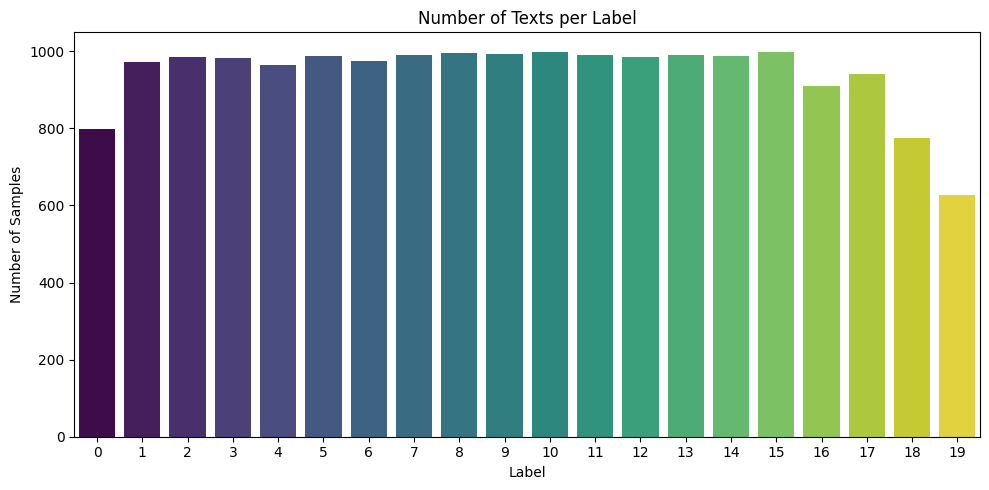

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
label_counts = df['label'].value_counts().sort_index()

label_df = pd.DataFrame({
    "label": label_counts.index,
    "count": label_counts.values
})

plt.figure(figsize=(10, 5))
sns.barplot(data=label_df, x="label", y="count", hue="label", palette="viridis", legend=False)

plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.title("Number of Texts per Label")
plt.tight_layout()
plt.show()


# Modeling / Model Evaluation

In [11]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=5,
        verbose=-1
    ),
}


In [12]:
def evaluate_multiclass_model(
    y_test,
    y_pred,
    y_score,
    class_names,
    top_k=3,
    show_report=False
):
    """
    Evaluate a multi-class classification model and return metrics as a dictionary.

    Parameters:
    - y_test: True labels (integers)
    - y_pred: Predicted labels (integers)
    - y_score: Predicted class probabilities (shape: [n_samples, n_classes])
    - class_names: List of class names (strings)
    - top_k: Value of k for Top-k Accuracy (default: 3)
    - show_report: Whether to return the classification report (default: False)

    Returns:
    - A dictionary of evaluation metrics
    """

    n_classes = len(class_names)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "log_loss": log_loss(y_test, y_score),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
        "cohen_kappa": cohen_kappa_score(y_test, y_pred),
        "mcc": matthews_corrcoef(y_test, y_pred),
        f"top_{top_k}_accuracy": top_k_accuracy_score(y_test, y_score, k=top_k),
        "macro_auc": roc_auc_score(y_test_bin, y_score, average="macro"),
    }

    if show_report:
        metrics["classification_report"] = classification_report(
            y_test, y_pred, target_names=class_names, output_dict=True
        )

    return metrics

In [13]:
def plot_multiclass_roc(y_test, y_score, class_names):
    """
    Plot ROC curves for multi-class classification using One-vs-Rest approach.

    Parameters:
    - y_test: True labels (integers)
    - y_score: Predicted probabilities (shape: [n_samples, n_classes])
    - class_names: List of class names
    """
    n_classes = len(class_names)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right", fontsize='small')
    plt.grid()
    plt.show()


Evaluating: Naive Bayes


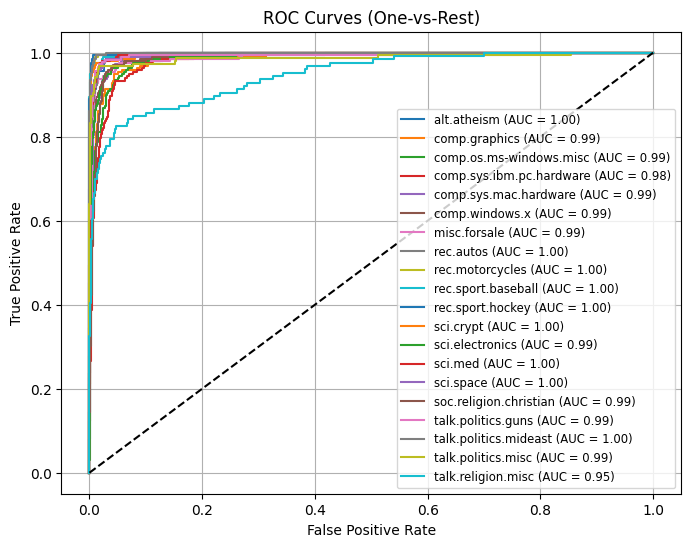

Evaluating: Logistic Regression


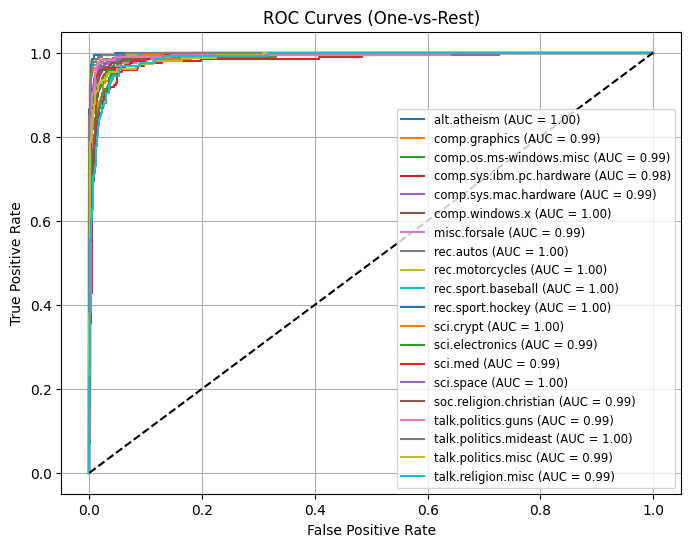

Evaluating: Random Forest


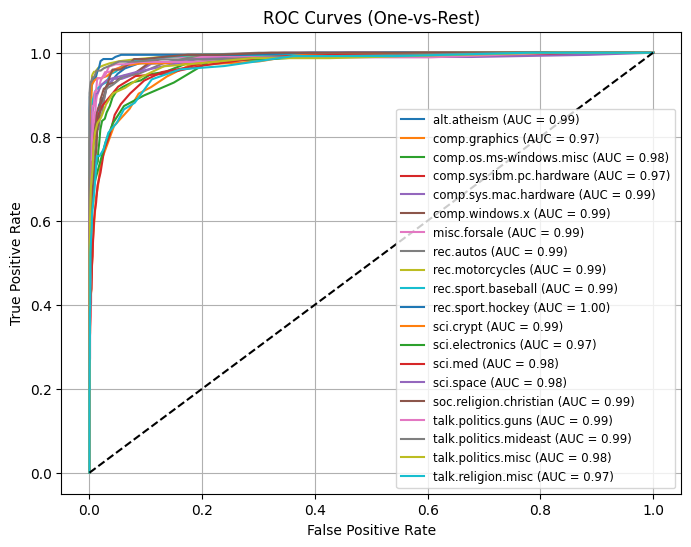

Evaluating: LightGBM
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[304]	valid_0's multi_logloss: 0.508871


/opt/anaconda3/envs/ml-supervised-classification-20newsgroups/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ml-supervised-classification-20newsgroups/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


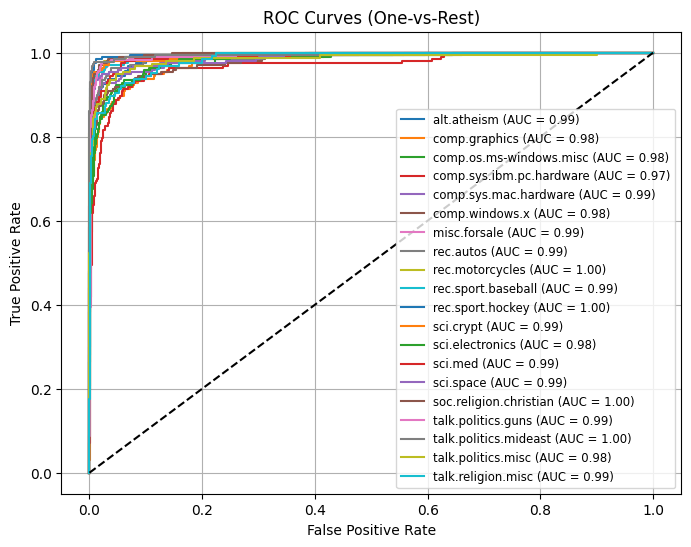

,accuracy,log_loss,f1_macro,f1_weighted,cohen_kappa,mcc,top_3_accuracy,macro_auc
model,,,,,,,,
Naive Bayes,0.8565,0.9801,0.8406,0.8513,0.8488,0.8503,0.9533,0.9912
Logistic Regression,0.8989,0.8787,0.8952,0.8984,0.8935,0.8937,0.9769,0.9937
Random Forest,0.8382,1.2047,0.8327,0.8365,0.8295,0.8300,0.9459,0.9842
LightGBM,0.8496,0.5488,0.8503,0.8513,0.8416,0.8418,0.9432,0.9884


In [14]:
all_results = []

for model_name, clf in models.items():
    print(f"Evaluating: {model_name}")
    
    if model_name == "LightGBM":
        # 検証用の分割
        df_train_part, df_val_part = train_test_split(
            df_train, test_size=0.2, random_state=42, stratify=df_train["label"]
        )

        # 特徴とラベル
        X_train_part = df_train_part["text"].tolist()
        y_train_part = df_train_part["label"].tolist()
        X_val_part = df_val_part["text"].tolist()
        y_val_part = df_val_part["label"].tolist()

        # TF-IDF
        vectorizer = TfidfVectorizer()
        X_train_vec = vectorizer.fit_transform(X_train_part)
        X_val_vec = vectorizer.transform(X_val_part)
        X_test_vec = vectorizer.transform(X_test)

        # モデル学習と評価（※ toarray() でワーニング防止）
        clf.fit(
            X_train_vec.toarray(), y_train_part,
            eval_set=[(X_val_vec.toarray(), y_val_part)],
            eval_metric="multi_logloss",
            callbacks=[
                early_stopping(stopping_rounds=20),
                log_evaluation(period=0)
            ]
        )
        y_pred = clf.predict(X_test_vec.toarray())
        y_score = clf.predict_proba(X_test_vec.toarray())

    else:
        # その他モデル（パイプライン処理）
        model = make_pipeline(TfidfVectorizer(), clf)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    # 評価指標まとめ
    results = evaluate_multiclass_model(
        y_test=y_test,
        y_pred=y_pred,
        y_score=y_score,
        class_names=newsgroups.target_names,
        show_report=False
    )
    results["model"] = model_name
    all_results.append(results)

    # ROC曲線の描画
    plot_multiclass_roc(
        y_test=y_test,
        y_score=y_score,
        class_names=newsgroups.target_names
    )

# 結果まとめ表示
df_all = pd.DataFrame(all_results).set_index("model").round(4)
display(df_all)
